# Scatter Ptychography: a simulation demo
### Qian Huang
### 03/14/2022

This notebook produces Fig. 4b) in OPTICA paper: *Scatter Ptychography*.

### REQUIRED PACKAGES ###
* opencv
* scikit-image
* scipy
* torch 1.9.0+cu102
* numpy

In [1]:
#https://pytorch.org/blog/the-torch.fft-module-accelerated-fast-fourier-transforms-with-autograd-in-pyTorch/

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import block_reduce
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

_seed = 19971017

random.seed(_seed)
np.random.seed(_seed % 2**32)
torch.manual_seed(_seed)

device='cuda'

In [2]:
def print_stat(narray, narray_name = 'Array'):
    print(narray_name + f" shape: {narray.shape}, dtype: {narray.dtype}")
    arr = narray.flatten()
    print(narray_name + " stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def pad_to_size(img, size):
    h, w = img.shape
    left = (size - w)//2
    top = (size - h) //2
    return F.pad(img, (left, size-w-left, top, size-h-top))

def crop_to_size(img, size, offset=-1):
    h, w = img.shape
    left = (w - size)//2+offset 
    top = (h - size)//2+offset
    return img[top:top+size, left:left+size]

def show_stats(complex_img):
    plt.imshow(torch.abs(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Amplitude')
    plt.show()
    print_stat(torch.abs(complex_img),'Amplitude')
    plt.imshow(torch.angle(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Phase')
    plt.show()
    print_stat(torch.angle(complex_img),'Phase')
    
def save2png(path, img):
    if isinstance(img, torch.Tensor):
        if img.is_cuda:
            img = img.cpu()
        img = img.numpy()
    if img.dtype == np.complex128:
        img = np.abs(img)
    img = (img/img.max()*255.).astype(np.uint8)
    cv2.imwrite(path, img)

In [3]:
def CUASD(f, d, lam, p):
    # INPUT
    ## f: input field
    ## d: distance in m
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    # OUTPUT
    ## g: output field
    pad = int((d*lam/p**2))//2*2+2 if d > 0 else 0
    inF = F.pad(f,(pad, pad, pad, pad))
    m, n = inF.size()
    urange = torch.linspace(-m/(2*p*m), (m-1)/(2*p*m), m).double()
    vrange = torch.linspace(-n/(2*p*n), (n-1)/(2*p*n), n).double()
    v, u = torch.meshgrid(vrange,urange)
    h = torch.exp(1j*2*np.pi*d*torch.sqrt((1/lam)**2 - u**2 - v**2)).to(device)
    g = torch.fft.ifft2(torch.fft.fftshift(h) * torch.fft.fft2(inF))
    return g

def cu_rescale(img, scale):
    return F.interpolate(img.unsqueeze(0).unsqueeze(0), scale_factor=scale,mode='bicubic').squeeze()


def CUMASD(f, d, lam, p, x):
    # INPUT
    ## f: input field
    ## d: distance in m, positive
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    ## x: object size in m
    # OUTPUT
    ## g: output field
    ## p_out: output field pixel pitch
    g = f
    p_out = p
    h_prev = 0
    while 2*(2*p_out)*x/lam*(p_out/p) < d:
        h = 2*(2*p_out)*x/lam*(p_out/p)
        g = CUASD(g, h-h_prev, lam, p_out)
        g = cu_rescale(torch.real(g),0.5)+1j*cu_rescale(torch.imag(g),0.5)
        h_prev = h
        p_out = 2*p_out
    g = CUASD(g, d-h_prev, lam, p_out)
    return g, p_out

def CURMASD(g, d, lam, p_out, p, x):
    # INPUT
    ## g: field to be back propagated
    ## d: reversal distance in m, positive
    ## lam: wavelength in m
    ## p_out: pixel pitch of g in m
    ## p: tolerable pixel pitch of f in m
    ## x: object size in m
    # OUTPUT
    ## f: reversed field
    ## p_in: pixel pitch of reversed field
    f = g
    p_in = p_out
    h_prev = d
    while p_in > p:
        h = 2*p_in*x/lam*(p_in/2/p)
        f = CUASD(f, h-h_prev, lam, p_in)
        pad = int((-(h-h_prev)*lam/p_in**2)//2*2+2)
        f = f[pad:-pad, pad:-pad]# remove padding
        f = cu_rescale(torch.real(f),2)+1j*cu_rescale(np.imag(f),2)
        h_prev = h
        p_in = p_in/2
    f = CUASD(f, -h_prev, lam, p_in)
    return f, p_in

## Forward Model

### propagation

In [4]:
def forward_proc(offset, inspect=False, base=104.):
    theta = 1e-10

    unit = 10e-6#40e-6
    lam = 0.532e-6
    assert 2*unit < np.abs(lam/np.sin(theta))
    N = 1000
    urange=torch.arange(-N//2, N//2).double()
    vrange=torch.arange(-N//2, N//2).double()
    UU, VV = torch.meshgrid(vrange,urange)
    lf = torch.exp(1j*2*np.pi/lam*(UU*unit*np.sin(1e-10))).to(device)

    obj = cv2.imread('USAF_Resolution_Chart_A1-780.jpg', 0)
    obj = cv2.resize(obj, (0,0), fx=0.58, fy=0.52)/255.0
    obj = torch.from_numpy(obj.astype(np.complex128)).to(device)
    obj = pad_to_size(obj,N)*(1-1e-10)+1e-10
    of = lf*obj

    z = (base*25.4+offset)*1e-3
    x = 4e-3
    sf, p_out = CUMASD(of, z, lam, unit, x)

    return sf

### cast to the camera

In [5]:
class Camera:
    def __init__(self, fl, p, m, n, bits=None, sigma=None, expo=None):
        self.fl = fl
        self.p = p
        self.m = m
        self.n = n
        self.sensor_img = None
        self.noise_params = sigma
        self.dynamic_range = bits
        self.expo = expo
    
    ### projection
    def sensor2wall(self, img, R, t, range_x, range_y, pitch):
        ## R, t: world coor plane (Z=0) to cam coor
        x, y = np.arange(-range_x, range_x, pitch), np.arange(-range_y, range_y, pitch)
        X, Y = np.meshgrid(x, y)
        p = np.stack([X,Y,np.ones_like(X)*0.0],axis=0)
        p = p.reshape((3, -1))
        p_cam=R.dot(p-t)
        X_cam, Y_cam = self.fl*p_cam[0]/p_cam[2], self.fl*p_cam[1]/p_cam[2]
        X_cam = X_cam.reshape(X.shape)
        Y_cam = Y_cam.reshape(Y.shape)
        X_coor, Y_coor = X_cam/self.p, Y_cam/self.p
        size = int(max(X_coor.max()-X_coor.min(), Y_coor.max()-Y_coor.min()))
        image_on_screen = Camera.bilinear_interp(np.pad(img,((size,size),(size,size)))
                                                      , Y_coor, X_coor)
        return image_on_screen

    def wall2sensor(self,img, R, t, pitch):
        ## R, t: world coor plane (Z=0) to cam coor
        ratio = 1
        while self.p/ratio*np.linalg.norm(t)/self.fl > 2*pitch:
            ratio += 1
        X_coor, Y_coor = np.meshgrid(np.arange(-(self.n*ratio)//2,(self.n*ratio)//2),np.arange(-(self.m*ratio)//2,(self.m*ratio)//2))
        X_cam, Y_cam = X_coor*self.p/ratio, Y_coor*self.p/ratio

        Z = -t[2]/(R[2, 2]+X_cam*R[0, 2]/self.fl) ## (x,y,z) in cam coor on the screen satisfies R^T.dot([x, y, z])_3 + t_3 = 0 (plane z=0) => ...

        p_cam = np.stack([X_cam*Z/self.fl, Y_cam*Z/self.fl, Z]).reshape((3,-1))
        p = R.T.dot(p_cam)+t
        Xs_coor, Ys_coor = p[0]/pitch, p[1]/pitch
        Xs_coor, Ys_coor = Xs_coor.reshape(X_coor.shape), Ys_coor.reshape(Y_coor.shape)
        size = int(max(Xs_coor.max()-Xs_coor.min(), Ys_coor.max()-Ys_coor.min()))
        self.sensor_img = Camera.bilinear_interp(np.pad(img,((size,size),(size,size))), Ys_coor, Xs_coor)
        if ratio > 1:
            self.sensor_img = Camera.binning(self.sensor_img, ratio)
            print(ratio)

    def read_out_img(self):
        img = self.sensor_img
        if self.expo is not None:
            img = Camera.confine_exposure(img, self.expo)
        if self.dynamic_range is not None:
            img = Camera.confine_dynamic_range(img, self.dynamic_range)
        if self.noise_params is not None:
            img = Camera.add_gauss_noise(img, self.noise_params)
        return img

    @staticmethod
    def bilinear_interp(img, Y_coor, X_coor):
        Y_coor_int, X_coor_int = np.floor(Y_coor).astype('int'), np.floor(X_coor).astype('int')
        delta_Y, delta_X = Y_coor-Y_coor_int, X_coor-X_coor_int
        m, n = img.shape
        Y_coor_int, X_coor_int = Y_coor_int+m//2, X_coor_int+n//2

        img_interp=(1-delta_Y)*(1-delta_X)*img[Y_coor_int,X_coor_int]+\
                        (delta_Y)*(1-delta_X)*img[Y_coor_int+1,X_coor_int]+\
                        (1-delta_Y)*(delta_X)*img[Y_coor_int,X_coor_int+1]+\
                        (delta_Y)*(delta_X)*img[Y_coor_int+1,X_coor_int+1]
        return img_interp

    @staticmethod
    def binning(img, ratio):
        return block_reduce(img, block_size=(ratio,ratio), func=np.mean)

    @staticmethod
    def add_gauss_noise(img, sigma):
        return np.clip(img + sigma*np.random.normal(size=img.shape), 0., 1.)

    @staticmethod
    def confine_dynamic_range(img, bits):
        return (img*2**bits).astype(np.int)/2**bits

    @staticmethod
    def confine_exposure(img, expo):
        return np.clip(img*expo, 0., 1.)

In [6]:
theta = np.arcsin(1/5.478)
R = np.array([[np.cos(theta), 0, -np.sin(theta)],
     [0, 1, 0],
     [np.sin(theta), 0, np.cos(theta)]])
t = np.array([[-1*25.4, 0, -1*25.4/np.tan(theta)]]).T #mm
cam = Camera(12, 6.9e-3, 540, 720)

## Phase Retrieval

/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


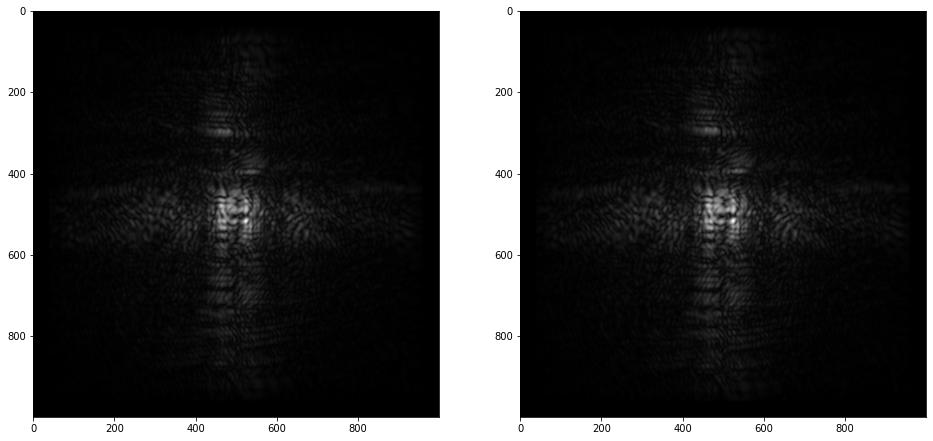

In [7]:
measurements=[]
z = []
k = 1
num_planes= 2
fig = plt.figure(figsize=(16, 8))
for offset in np.linspace(0, 50, num_planes):
    offset = int(offset)
    base = 104.5
    z.append((base*25.4+offset)*1e-3)
    img = forward_proc(offset, base=base)
    m, n = img.shape
    
    img_amp = cu_rescale(torch.abs(img)**2, 0.5)
    cam.wall2sensor(img_amp.to('cpu').numpy(), R, t, 80e-3)
    img = np.sqrt(np.clip(cam.read_out_img()/cam.read_out_img().max(), 0, 1))
    img = img[40:-40,130:-130]
    
    img = cu_rescale(torch.from_numpy(img).to(device), 2)
    img = pad_to_size(img, m)
    measurements.append(img)
    plt.subplot(1,num_planes,k)
    plt.imshow(crop_to_size(torch.abs(img).to('cpu').numpy(),1000,0),cmap='gray')
    k+=1
plt.show()

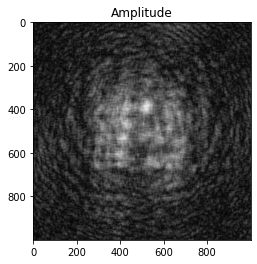

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.5479686152482428, min: 0.00011234876238900882, mean: 0.1064003182643341, std: 0.07155924299600082


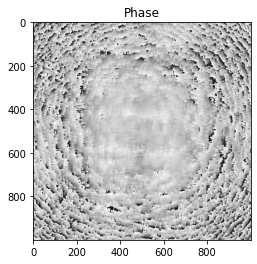

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141588843539535, min: -3.1415851766740235, mean: 1.3885462618166062, std: 1.2369982958042358


In [8]:
unit = 10e-6
lam = 0.532e-6

index_c = 0
field_at_target_inv, p_in = CURMASD(torch.abs(measurements[index_c])*torch.exp(1j*(torch.randn_like(torch.abs(measurements[index_c])))), z[index_c], lam, 40e-6, unit, 4e-3)#ASD(measurements[index_c], -z[index_c], lam, unit)
show_stats(crop_to_size(field_at_target_inv, 1000, 0))

In [9]:
def calc_lf(N):
    theta = 1e-10
    urange=torch.arange(-N//2, N//2).double()
    vrange=torch.arange(-N//2, N//2).double()
    UU, VV = torch.meshgrid(vrange,urange)
    lf = torch.exp(1j*2*np.pi/lam*(UU*unit*np.sin(theta))).to(device)
    return lf

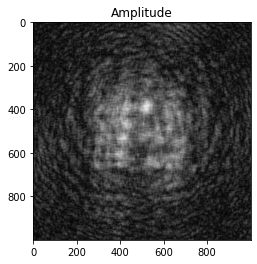

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.5479686152482428, min: 0.0001123487623890088, mean: 0.1064003182643341, std: 0.07155924299600083


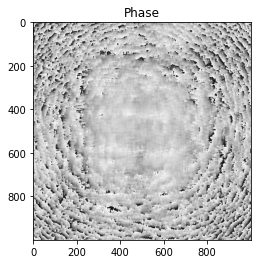

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141578017961834, min: -3.1415905938221984, mean: 1.3885399845365485, std: 1.2370053777489494


In [10]:
target_est = field_at_target_inv/calc_lf(field_at_target_inv.shape[0])  ## initial estimation
target_est = crop_to_size(target_est, 1000, 0)
show_stats(target_est)

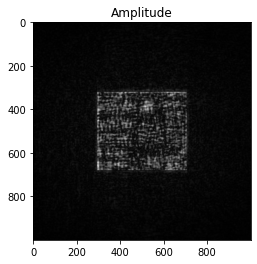

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.432375820424682, min: 3.58069573333309e-05, mean: 0.1199300462454974, std: 0.19982783895799192


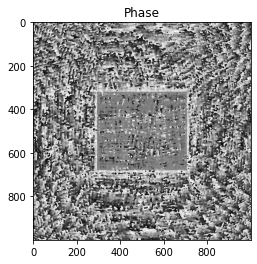

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141582235333142, min: -3.1415910782310714, mean: 0.06431852313464806, std: 1.7114029122242158


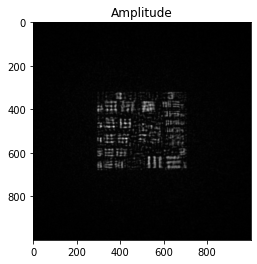

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.485091473701342, min: 5.657326608687953e-05, mean: 0.08672771740902549, std: 0.22014559601815237


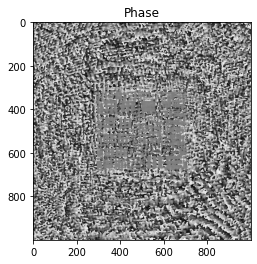

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415840953368286, min: -3.1415908081010335, mean: -0.0021076775482209704, std: 1.724967683827561


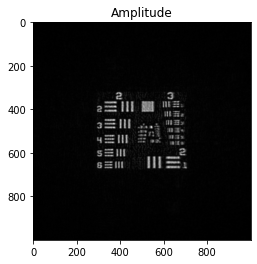

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.6603589632036604, min: 1.4854386620665435e-05, mean: 0.07443998314620781, std: 0.23832223085773618


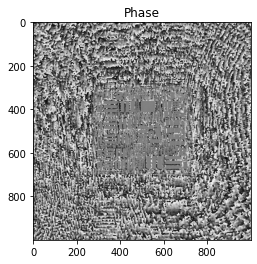

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141587236037162, min: -3.1415872796850794, mean: 0.00947932562051378, std: 1.7025283012195627


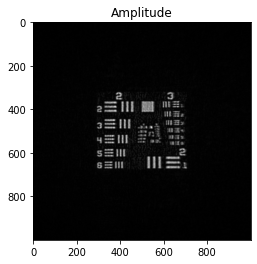

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.518173653407982, min: 4.2745418528261606e-05, mean: 0.07008570706115587, std: 0.22645233881849094


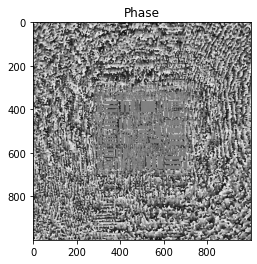

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141578460790301, min: -3.1415898152541257, mean: -0.005900811667238491, std: 1.710336666841756


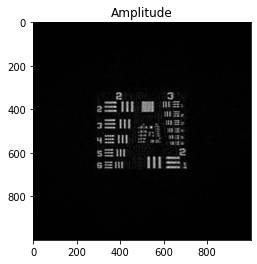

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.5060438370903757, min: 2.3810074918113096e-05, mean: 0.06998201743632497, std: 0.22648812825841289


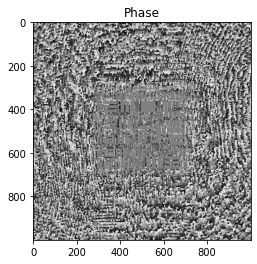

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415886315868566, min: -3.141579344970674, mean: -0.0045709284601159255, std: 1.7109775933286824


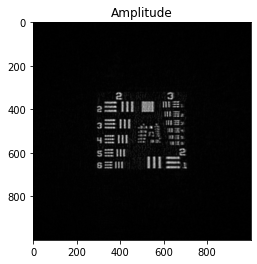

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.4871098900688358, min: 1.7015909122949786e-05, mean: 0.06999938146044123, std: 0.22648165604842785


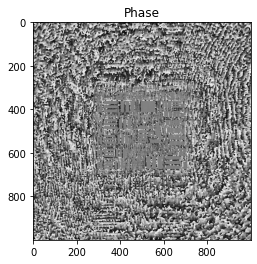

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415869714008196, min: -3.1415906091059704, mean: -0.003692386636116256, std: 1.7107838366608834


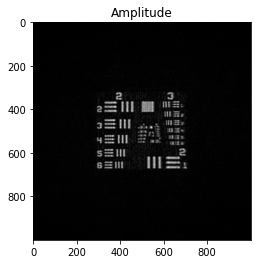

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.477489222605574, min: 1.3970628703726626e-05, mean: 0.06997574395519489, std: 0.22649007357624049


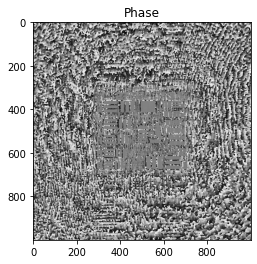

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415843139885897, min: -3.141592514375756, mean: -0.0034025739503830144, std: 1.7106275997381684


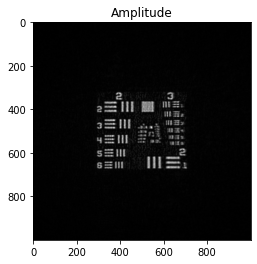

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.475834213463462, min: 2.193442457261895e-05, mean: 0.06996524480343479, std: 0.2264936186872384


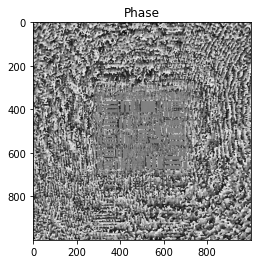

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415708900279706, min: -3.141592469805256, mean: -0.0036314017733778993, std: 1.7107037621858348


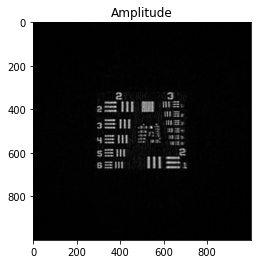

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.4737582705186485, min: 8.28901441846117e-06, mean: 0.06995569688077655, std: 0.2264964862284884


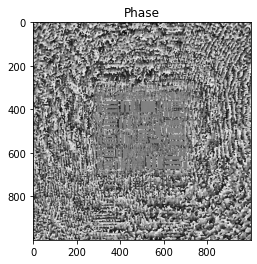

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415894002489617, min: -3.1415880249000674, mean: -0.003925984027358231, std: 1.7105974870136276


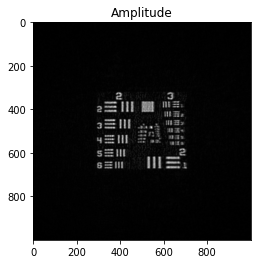

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.473107001377089, min: 2.008712568048563e-05, mean: 0.06996452987342272, std: 0.2264936045421497


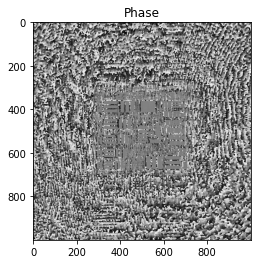

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415813313857424, min: -3.141591052711587, mean: -0.003957495703025598, std: 1.710610064295192


In [11]:
# %%time
measurements_est = [i.cdouble() for i in measurements]
n = 500
for iter in range(n):
    idx_list = list(range(num_planes))
    random.shuffle(idx_list)
    for i in idx_list:
        h_pad, w_pad = 320, 294
        target_est = torch.abs(target_est)
        target_est[:h_pad] = 1e-10
        target_est[-h_pad:] = 1e-10
        target_est[:,:w_pad] = 1e-10
        target_est[:,-w_pad:] = 1e-10
        field_at_target = calc_lf(1000)*target_est.cdouble()
        sc, p_out = CUMASD(field_at_target, z[i], lam, unit, 4e-3)
        measurements_est[i] = torch.abs(measurements[i]).cdouble()*torch.exp(1j*torch.angle(sc))
        field_at_target_inv, p_in = CURMASD(measurements_est[i], z[i], lam, p_out, unit, 4e-3)
        target_est = crop_to_size(field_at_target_inv/calc_lf(field_at_target_inv.shape[0]), 1000, 0)
    if iter % 50 == 0:
        show_stats(crop_to_size(target_est, 1000, 0))

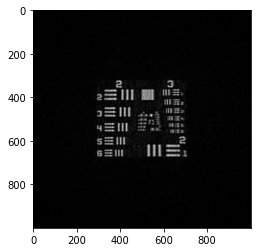

In [12]:
plt.imshow(torch.abs(target_est).to('cpu').numpy(), cmap='gray')
plt.show()

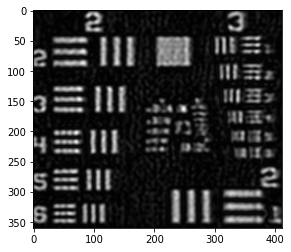

In [13]:
plt.imshow(torch.abs(target_est).to('cpu').numpy()[h_pad:-h_pad, w_pad:-w_pad], cmap='gray')
plt.show()